In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from IPython.core.interactiveshell import InteractiveShell
import pmdarima as pm
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
TRAIN_SIZE = 0.85

In [3]:
df = pd.read_csv('solar_rad.csv')
train_records = int(len(df)*TRAIN_SIZE)
train = df.loc[:train_records, :]
test = df.loc[train_records:, :]

In [4]:
train.tail(3)

,time,temperature,global_radiation
33182,2015-04-13 10:10:00,18.41,1023.48
33183,2015-04-13 11:10:00,18.98,995.69
33184,2015-04-13 12:10:00,19.55,960.46


In [5]:
test.head(3)

,time,temperature,global_radiation
33184,2015-04-13 12:10:00,19.55,960.46
33185,2015-04-13 13:10:00,19.11,836.99
33186,2015-04-13 14:10:00,18.67,792.27


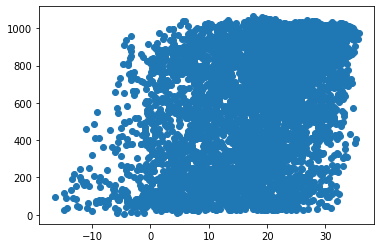

In [6]:
plt.scatter(test['temperature'], test['global_radiation'])

In [7]:
test.corr()
train.corr()

,temperature,global_radiation
temperature,1.000000,0.435217
global_radiation,0.435217,1.000000


,temperature,global_radiation
temperature,1.000000,0.403622
global_radiation,0.403622,1.000000


<AxesSubplot:>

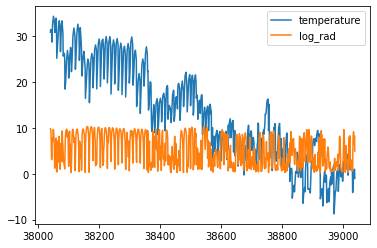

In [8]:
# temperature is hard to forecast but still could it help?
log_df = df.copy()
# convert W/m^2 -> 10^-2 W/m^2 for visuaization
log_df['log_rad'] = df.global_radiation/100 
log_df.drop('global_radiation', inplace=True, axis=1)
log_df[-1000:].plot()

<AxesSubplot:>

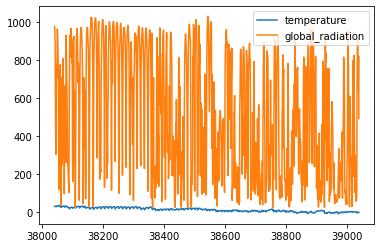

In [9]:
df[-1000:].plot()

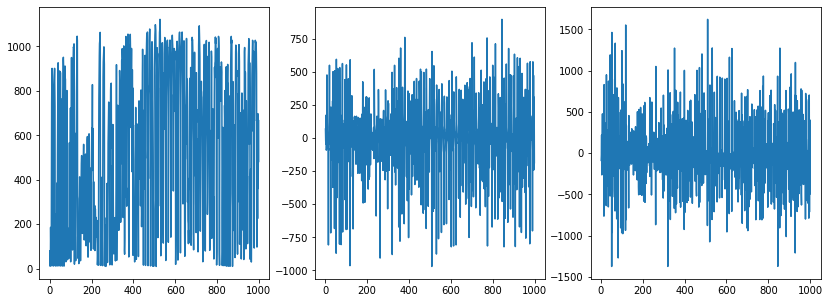

In [10]:
# can we make our series stationary?
fig, ax = plt.subplots(1, 3, figsize=(14,5))
ax[0].plot(df[:1000].global_radiation);
ax[1].plot(df[:1000].global_radiation.diff());
ax[2].plot(df[:1000].global_radiation.diff().diff());

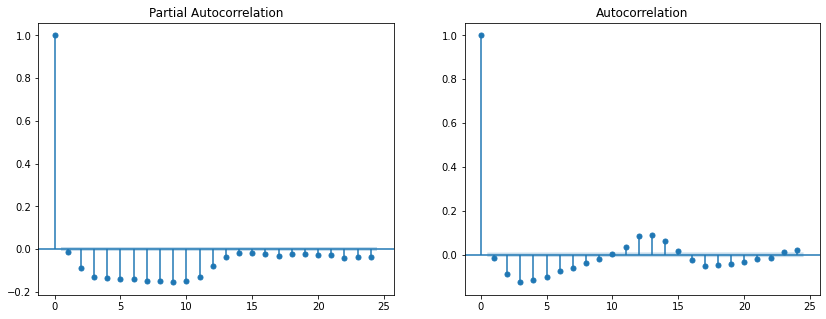

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
lags = 24
plot_pacf(df.global_radiation.diff().dropna(), lags=lags, ax=ax[0]);
plot_acf(df.global_radiation.diff().dropna(), lags=lags, ax=ax[1]);

In [12]:
adfuller(df.global_radiation)

(-13.897844587999606,
 5.807320181234596e-26,
 54,
 38985,
 {'1%': -3.430517749919921,
  '5%': -2.8616141415578356,
  '10%': -2.566809463179514},
 527250.9212027533)

(-13.897844587999606, - test staticstic, reject stationarity hypothesis <br>
 5.807320181234596e-26, - p-value <br>
 54, - lags used <br>
 38985, - number of obervations <br>
 {'1%': -3.430517749919921,
  '5%': -2.8616141415578356,
  '10%': -2.566809463179514}, - critical values for the test statistic <br>
 527250.9212027533) - maximized information criterion

ARIMA algoritm might help here but time series will require much more steps to be utilized with it or any other methods of classical time series statistics. Here we are not concerned with too precise values, however, but with a good enough estimation of solar power radiation. Let's feed a simple recurrent network so there is not as much manual work which would be done with ARIMA, GARCH etc.

In [13]:
df['day'] = df.time.apply(lambda x: x.split(' ')[0])

In [14]:
rads = df.groupby(by='day').max().global_radiation

In [15]:
df.global_radiation.max()

1121.37

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm

loss_fn = nn.MSELoss()

def get_sequences(df, seq_len):
    for i in range(len(df)-seq_len-1):
        x = df[i:(i+seq_len)].values
        y = df.loc[df.index[i+seq_len]]
        yield torch.tensor(x), torch.tensor(y)

class BaseModel(nn.Module):
    
    def training_step(self, x, y, loss_f=F.mse_loss):
        x, y = x.float(), y.float()
        out = self(x)
        loss = loss_f(out, y)      
        return loss
    
    def validation_step(self, x, y, loss_f=F.mse_loss):
        x, y = x.float(), y.float()
        out = self(x)
        loss = loss_f(out, y)
        return loss        

        
class StatefulModel(BaseModel):
    
    def __init__(self, n_features, n_hidden, seq_len=14, 
                 n_layers=2, out_features=1):
        
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden = None
        self.lstm1 = nn.LSTM(n_features, 
                            n_hidden, 
                            n_layers,
                            dropout=0.5)
        
        self.lstm2 = nn.LSTM(n_hidden, 
                            n_hidden, 
                            n_layers,
                            dropout=0.5)
        self.linear = nn.Linear(n_hidden, out_features)
    
    def init_hidden(self, x):
        self.hidden = (torch.rand((self.n_layers, x.shape[0], self.n_hidden)),
                       torch.rand((self.n_layers, x.shape[0], self.n_hidden)))
    
    def forward(self, x):
        if self.hidden is None:
            self.init_hidden(x)
        x = x.view(1, self.seq_len, -1).float()
        lstm_out, self.hidden = self.lstm1(x, self.hidden)
        lstm_out, self.hidden = self.lstm2(lstm_out, 
                                           self.hidden)
        last_time_step = lstm_out.view(
            self.seq_len, len(x), self.n_hidden)[-1]
        x = self.linear(last_time_step)
        self.hidden = self.hidden[0].detach(), self.hidden[1].detach()
        return torch.flatten(x)
    
class SequenceDataset(Dataset):
    
    def __init__(self, series, window=24):
        self.series = series
        self.window = window
        
        self.seqs = list(get_sequences(self.series, self.window))
        
    def __getitem__(self, idx):
        return self.seqs[idx]
    
    def __len__(self):
        return len(self.seqs)

In [17]:
model = StatefulModel(1, 128, 24)
model

StatefulModel(
  (lstm1): LSTM(1, 128, num_layers=2, dropout=0.5)
  (lstm2): LSTM(128, 128, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
epochs = 5
lr = 0.001
window = 24
optimizer = Adam(model.parameters(), lr)

In [19]:
def normalize(x, mu, sigma):
    return (x-mu)/sigma

def denormalize(x, mu, sigma):
    return (x*sigma)+mu

In [20]:
mu = df.global_radiation.mean()
sigma = df.global_radiation.std()

In [21]:
normalize(train.global_radiation, mu, sigma)
denormalize(np.array([-1, 0, 0.5]), mu, sigma)

0       -1.815338
1       -1.608661
2       -1.673192
3       -1.815460
4       -1.286924
           ...   
33180    1.234386
33181    1.291471
33182    1.279000
33183    1.193847
33184    1.085897
Name: global_radiation, Length: 33185, dtype: float64

array([279.71888593, 606.07300717, 769.25006779])

In [22]:
if not os.path.exists('model.pth'):
    for epoch in range(epochs):

        total_loss = []
        model.train()


        train_seqs = normalize(train.global_radiation, mu, sigma)
        test_seqs = normalize(test.global_radiation, mu, sigma)

        train_gen = get_sequences(train_seqs, 24)
        test_gen = get_sequences(test_seqs, 24)

        pbar = tqdm(train_gen, total=len(train)-25, miniters=64)

        for i, (x, y) in enumerate(pbar):
            pbar.set_description('Training')
            loss = model.training_step(x, y, loss_fn)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            optimizer.zero_grad()
            if i%64==0:
                pbar.set_postfix({'loss': loss.item()})
            if i%1024==0:
                print('Sanity check predction:', model(x))
                

        t_loss = np.array(total_loss).mean()

        total_loss = []
        model.eval()

        pbar = tqdm(test_gen, total=len(test)-25, miniters=64)

        for i, (x, y) in enumerate(pbar):

            pbar.set_description('Validation')
            loss = model.validation_step(x, y, loss_fn)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())

            if i%64==0:
                pbar.set_postfix({'loss': loss.item()})

        t_loss = np.array(total_loss).mean()
        print('[Validation] Epoch: {}, loss: {}'.format(
            epoch, t_loss))
    torch.save(model.state_dict(), 'model.pth')
else:
    model.load_state_dict(torch.load('model.pth'))
model.eval()

<All keys matched successfully>

StatefulModel(
  (lstm1): LSTM(1, 128, num_layers=2, dropout=0.5)
  (lstm2): LSTM(128, 128, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)